In [1]:
import os
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext, SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '2g')
SparkContext.setSystemProperty('spark.driver.cores', '2')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='preprocess_crime_locations')

In [2]:
from pyspark.sql.types import *
sqlContext = SQLContext(sc)
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pandas as pd
from pyspark.sql.window import Window
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import datetime

In [3]:
df = sqlContext.read.csv("/datasets/crimes.csv", header='true')
df.count()

7063815

In [4]:
df.agg(F.countDistinct(F.col("Location Description"))).show()

+---------------------------+
|count(Location Description)|
+---------------------------+
|                        180|
+---------------------------+



In [11]:
df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) \
           for (c,col_type) in df.dtypes if col_type not in ('date')]).select("Location Description").show()

+--------------------+
|Location Description|
+--------------------+
|                6201|
+--------------------+



In [14]:
print("6201 Location Descriptions are not recorded in the dataset, which is ", round(6201/7063815,5),"% of the dataset")

6201 Location Descriptions are not recorded in the dataset, which is  0.00088 % of the dataset


## The distribution of Location Descriptions

In [15]:
#Group by count and sort in descending order before converting it to a pandas dataframe
loc_desc = df.groupBy("Location Description").count().sort(F.col("count").desc())
df_loc_desc = loc_desc.toPandas().set_index('Location Description')

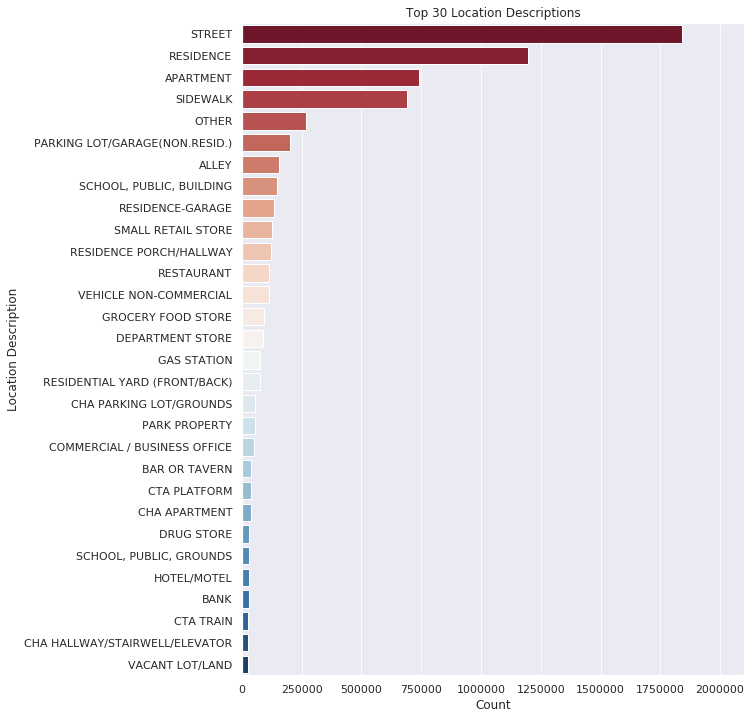

In [18]:
sns.set(rc={'figure.figsize':(9,12)})
top_df_loc_desc = df_loc_desc[:30]

ax = sns.barplot(y=top_df_loc_desc.index, 
                 x=top_df_loc_desc['count'], 
                 palette=sns.color_palette("RdBu", len(top_df_loc_desc)),
                 zorder=2,
                 data=top_df_loc_desc)

for tick in ax.get_xticks():
    ax.axvline(x=tick, alpha=0.5, color='#eeeeee', linestyle='dashed', zorder=1)    
    
ax.set_title("Top 30 Location Descriptions")
ax.set_xlabel('Count')
ax.set_ylabel('Location Description')
plt.show()

In [21]:
total = sum(top_df_loc_desc["count"].values)
print(top_df_loc_desc["count"].apply(lambda x: (int(x)/total)*100))
print("\n\nThe top 15 types represent",
      round(sum(top_df_loc_desc["count"].apply(lambda x: (int(x)/total)*100)[:15].values),2),
     "% of the crimes in this dataset")

Location Description
STREET                            27.611135
RESIDENCE                         17.961023
APARTMENT                         11.115468
SIDEWALK                          10.351225
OTHER                              4.049528
PARKING LOT/GARAGE(NON.RESID.)     3.044283
ALLEY                              2.356009
SCHOOL, PUBLIC, BUILDING           2.194790
RESIDENCE-GARAGE                   2.034547
SMALL RETAIL STORE                 1.918423
RESIDENCE PORCH/HALLWAY            1.862156
RESTAURANT                         1.712815
VEHICLE NON-COMMERCIAL             1.711764
GROCERY FOOD STORE                 1.372898
DEPARTMENT STORE                   1.345913
GAS STATION                        1.147964
RESIDENTIAL YARD (FRONT/BACK)      1.126535
CHA PARKING LOT/GROUNDS            0.842390
PARK PROPERTY                      0.813813
COMMERCIAL / BUSINESS OFFICE       0.768853
BAR OR TAVERN                      0.580544
CTA PLATFORM                       0.565693
CHA APARTME

## Temporal analysis

We will analyse where crimes happens during the day and week

In [22]:
df = (df
       .withColumn('Timestamps', F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn("Hour", F.hour("Timestamps"))
       .withColumn("DayOfWeek", F.dayofweek("Day"))
      )

In [26]:
#Returns Location Description below a certain threshold (We use 1%)
def least_frequent_columns(df,threshold=0.01):
    res = df.groupBy("Location Description").count()\
                            .withColumn('tot',F.lit(df.count()))\
                            .withColumn('frac',F.expr('count/tot'))\
                            .filter('frac<'+str(threshold))\
                            .select("Location Description")\
                            .rdd.flatMap(lambda x: x)\
                            .collect()
    return res

lfc = least_frequent_columns(df)

#User defined function which rename all columns below the threshold
@udf(StringType())
def renamer(label):
    if label in lfc:
        return "OTHER LOCATIONS"
    else:
        return label

In [28]:
# Apply the UDF which renames all Location Description with less than 1% share
df = (df.withColumn('LocationDescription', renamer(F.col('Location Description')))\
    .drop("Location Description")\
    .withColumnRenamed("LocationDescription","Location Description"))

### Daily analysis

In [29]:
lcd = (df.groupBy("Location Description","Hour")\
       .count()\
       .sort(F.col("Hour"))\
       .groupBy("Location Description")\
       .pivot("Hour")\
       .agg({"count":"max"})\
       .orderBy('Location Description'))

In [30]:
df_lcd = lcd.toPandas().set_index('Location Description')
df_lcd.shape

(18, 24)

We are dealing with 18 Location Descriptions after the filter

In [31]:
def min_max_scaler(_df):
    for idx, r in _df.iterrows():
        _df.loc[str(idx)] = minmax_scale(r.values)
    return _df

In [32]:
scaled_lcd = min_max_scaler(df_lcd.copy())

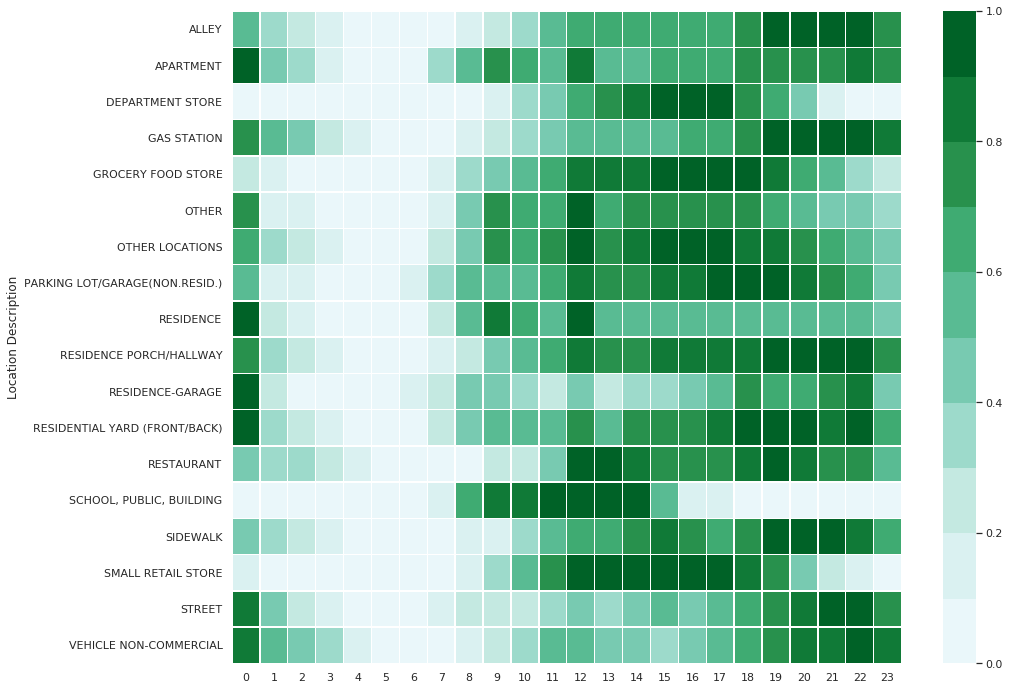

In [34]:
sns.set(rc={'figure.figsize':(15,12)})
ax = sns.heatmap(scaled_lcd,
                 linewidth=0.4,
                 cmap = sns.color_palette("BuGn",10)
                )
plt.show()

### Day Of Week

In [35]:
lcdow = (df.groupBy("Location Description","DayOfWeek")\
       .count()\
       .sort(F.col("DayOfWeek"))\
       .groupBy("Location Description")\
       .pivot("DayOfWeek")\
       .agg({"count":"max"})\
       .orderBy('Location Description'))

In [37]:
df_lcdow = lcdow.toPandas().set_index('Location Description')
df_lcdow.rename(columns={'1': '7', '2': '1','3':'2','4':'3','5':'4','6':'5','7':'6'},inplace=True)
df_lcdow = df_lcdow[[str(i) for i in np.arange(1,8)]] #Reorder

In [38]:
scaled_df_lcdow = min_max_scaler(df_lcdow.copy())

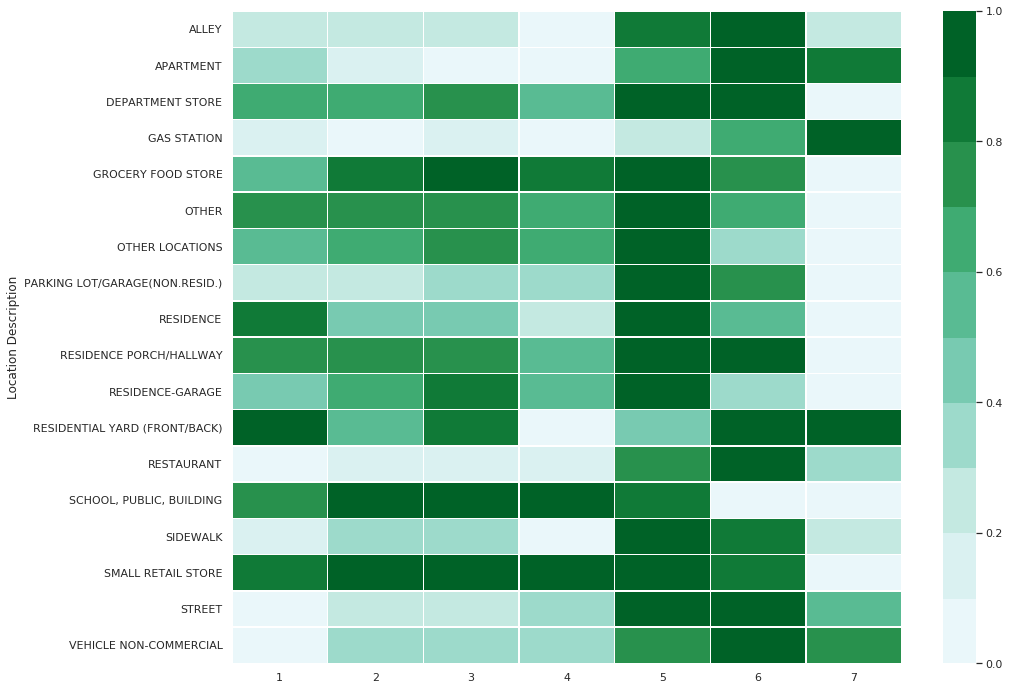

In [39]:
sns.set(rc={'figure.figsize':(15,12)},font_scale = 1)
ax = sns.heatmap(scaled_df_lcdow,
                 linewidth=0.4,
                 cmap= sns.color_palette("BuGn",10)
                )
plt.show()

### Trend analysis of Location Descriptions

In [84]:
daily_lc = (df\
            .groupBy("Day","Location Description")\
            .count()\
            .groupBy("Day")\
            .pivot("Location Description")\
            .agg({'count':'max'})\
            .drop("Location Description","null")\
            .orderBy('Day'))

#We have to clean them because pyspark cannot select names with special characters
tmp_list = [] 
for col in daily_lc.columns:
    new = col.replace('/',' ').replace('-',' ').replace('(','').replace(')','').replace(".", " ").strip()
    tmp_list.append(new) 
print("Column names after the cleaning: \n", tmp_list)

daily_lc = daily_lc.toDF(*tmp_list) 

Column names after the cleaning: 
 ['Day', 'ALLEY', 'APARTMENT', 'DEPARTMENT STORE', 'GAS STATION', 'GROCERY FOOD STORE', 'OTHER', 'OTHER LOCATIONS', 'PARKING LOT GARAGENON RESID', 'RESIDENCE', 'RESIDENCE PORCH HALLWAY', 'RESIDENCE GARAGE', 'RESIDENTIAL YARD FRONT BACK', 'RESTAURANT', 'SCHOOL, PUBLIC, BUILDING', 'SIDEWALK', 'SMALL RETAIL STORE', 'STREET', 'VEHICLE NON COMMERCIAL']


In [85]:
#Apply MA-120 on each Primary type
MA_120 = Window.orderBy("Day").rowsBetween(-120,0)

daily_lc_cols = daily_lc.columns
if "Day" in daily_lc_cols:
    daily_lc_cols.remove("Day")
    
daily_lc_MA = daily_lc
for p in daily_lc_cols:
    daily_lc_MA = daily_lc_MA.withColumn(p +'_120-MA', F.avg(p).over(MA_120))

daily_lc_MA = daily_lc_MA.drop(*daily_lc_cols)

ALLEY
APARTMENT
DEPARTMENT STORE
GAS STATION
GROCERY FOOD STORE
OTHER
OTHER LOCATIONS
PARKING LOT GARAGENON RESID
RESIDENCE
RESIDENCE PORCH HALLWAY
RESIDENCE GARAGE
RESIDENTIAL YARD FRONT BACK
RESTAURANT
SCHOOL, PUBLIC, BUILDING
SIDEWALK
SMALL RETAIL STORE
STREET
VEHICLE NON COMMERCIAL


In [86]:
daily_lc = daily_lc_MA.toPandas().set_index('Day')
daily_lc.isnull().sum()

ALLEY_120-MA                            0
APARTMENT_120-MA                        0
DEPARTMENT STORE_120-MA                 0
GAS STATION_120-MA                      0
GROCERY FOOD STORE_120-MA               0
OTHER_120-MA                            0
OTHER LOCATIONS_120-MA                  0
PARKING LOT GARAGENON RESID_120-MA      0
RESIDENCE_120-MA                        0
RESIDENCE PORCH HALLWAY_120-MA          0
RESIDENCE GARAGE_120-MA                 0
RESIDENTIAL YARD FRONT BACK_120-MA    181
RESTAURANT_120-MA                       0
SCHOOL, PUBLIC, BUILDING_120-MA         0
SIDEWALK_120-MA                         0
SMALL RETAIL STORE_120-MA               0
STREET_120-MA                           0
VEHICLE NON COMMERCIAL_120-MA           0
dtype: int64

<Figure size 1080x864 with 0 Axes>

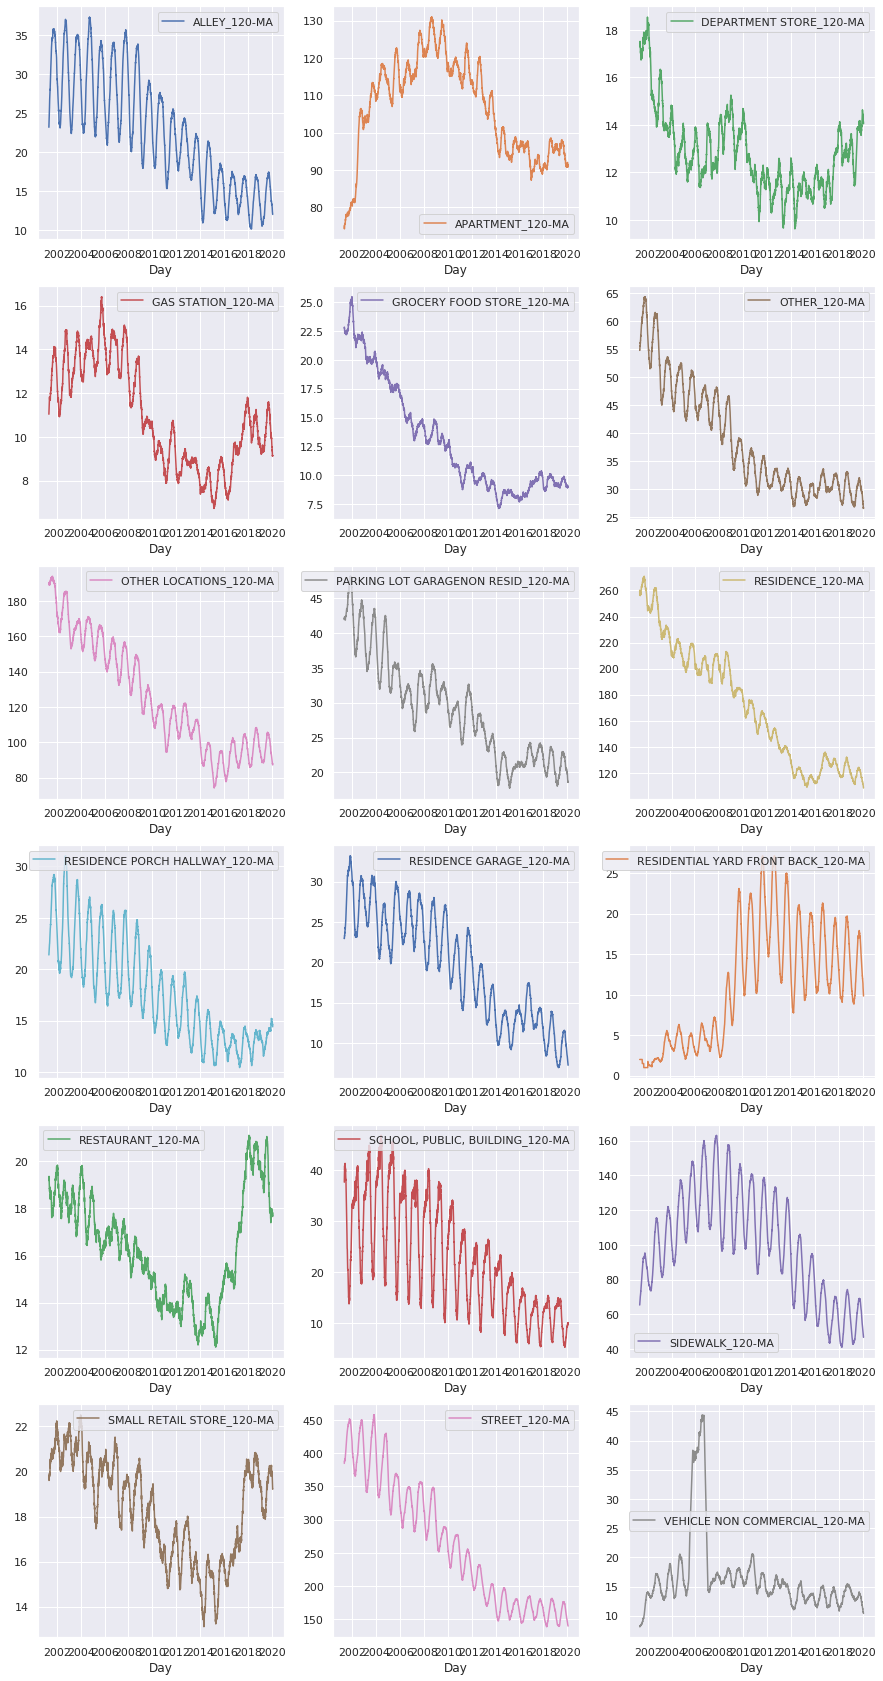

In [87]:
plt.clf()
daily_lc[120:].plot(figsize=(15, 30),
                   subplots=True,
                   layout=(-1, 3),
                   sharex=False,
                   sharey=False
                )
plt.show()

### Connection between location and type

We assume there is a strong correlation between the types of crime and where they occur

In [88]:
loc_type = (df.groupBy("Location Description","Primary Type")\
       .count()\
       .groupBy("Location Description")\
       .pivot("Primary Type")\
       .agg({"count":"max"}))

In [90]:
df_loc_type = loc_type.toPandas().set_index('Location Description')

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_loc_type = pd.DataFrame(scaler.fit_transform(df_loc_type), columns=df_loc_type.columns,
                               index=df_loc_type.index)

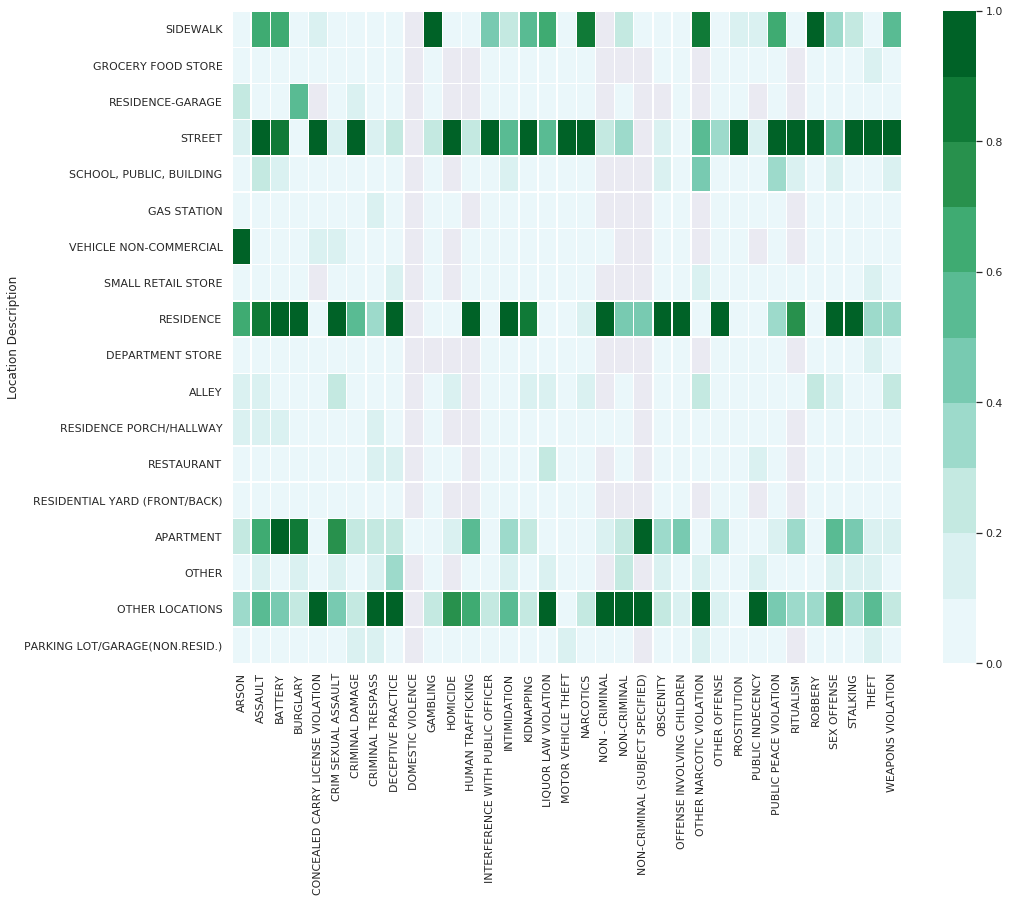

In [103]:
sns.set(rc={'figure.figsize':(15,12)},font_scale = 1)
ax = sns.heatmap(scaled_loc_type,
                 linewidth=0.4,
                 cmap= sns.color_palette("BuGn",10)
                )
plt.show()

### Where in the city does certain crimes appear

We want to check whether certain types of crime occur more frequently in special areas of the city. We have to clean the Primary Type column first

In [74]:
def least_frequent_columns(df,threshold=0.01):
    res = df.groupBy("Primary Type").count()\
                            .withColumn('tot',F.lit(df.count()))\
                            .withColumn('frac',F.expr('count/tot'))\
                            .filter('frac<'+str(threshold))\
                            .select("Primary Type")\
                            .rdd.flatMap(lambda x: x)\
                            .collect()
    return res



@udf(StringType())
def renamer(label):
    if label in lfc:
        return "OTHER CRIMES"
    else:
        return label
    
    
lfc = least_frequent_columns(df)


df = (df.withColumn('PrimaryType', renamer(F.col('Primary Type')))\
    .drop("Primary Type")\
    .withColumnRenamed("PrimaryType","Primary Type"))

In [75]:
df.groupBy("Latitude","Longitude","Primary Type").count().show()

+------------+-------------+------------------+-----+
|    Latitude|    Longitude|      Primary Type|count|
+------------+-------------+------------------+-----+
|41.896867117|-87.622495512|             THEFT|    4|
|41.794402813|-87.646541462|   CRIMINAL DAMAGE|    1|
|42.018927423|-87.668890237|           BATTERY|    1|
|41.799694692| -87.58601536|             THEFT|    1|
|41.958011997|-87.754040263|           BATTERY|    2|
|41.862426638| -87.72520478|           ROBBERY|    1|
|41.707029861|-87.625326722|      OTHER CRIMES|   21|
|41.691910137|-87.613205019|          BURGLARY|    1|
|41.877402355| -87.68951845|           BATTERY|   96|
|41.882116432|-87.765911867|   CRIMINAL DAMAGE|    2|
|41.882919521|-87.683888585|           ASSAULT|    1|
|41.900248094|-87.719060686|     OTHER OFFENSE|    2|
|41.749343529|-87.605417473|         NARCOTICS|   23|
|41.793385159|-87.625818353|           BATTERY|    1|
|41.903193968|-87.669966635|           BATTERY|    1|
|41.978569005|-87.802304678|

Lets filter the dataframe shown above. First of all filter the range of Latitude and Longitude since the dataset contains values far away from the main areas. Then we can round the values to a less specific location and drops null values.

In [98]:
rounded_loc_type = df\
.filter( (F.col("Latitude")>41.6) & (F.col("Latitude")<42.1))\
.filter((F.col("Longitude")>-87.9) & (F.col("Longitude")<-87.55))\
.withColumn("RoundedLong", F.round(df["Longitude"], 4))\
.withColumn("RoundedLat", F.round(df["Latitude"], 4))\
.groupBy("RoundedLong","RoundedLat","Primary Type")\
.count()\
.dropna(subset=['RoundedLong','RoundedLat'])

rounded_loc_type.show()

+-----------+----------+-------------------+-----+
|RoundedLong|RoundedLat|       Primary Type|count|
+-----------+----------+-------------------+-----+
|    -87.644|   41.7502|            ASSAULT|   55|
|   -87.6317|   41.8381| DECEPTIVE PRACTICE|    6|
|   -87.7239|   41.8808|            BATTERY|  209|
|   -87.6331|   41.8845| DECEPTIVE PRACTICE|   27|
|   -87.6517|   41.7642|            BATTERY|   23|
|   -87.7116|   41.8673|            ROBBERY|    5|
|   -87.6245|   41.8853| DECEPTIVE PRACTICE|    7|
|   -87.6197|   41.7025|          NARCOTICS|   13|
|    -87.658|    41.869|              THEFT|   17|
|   -87.7264|   41.9058|              THEFT|  235|
|    -87.745|   41.9534|              THEFT|  737|
|   -87.6546|    41.957|           BURGLARY|   13|
|   -87.6562|   41.9572|            ASSAULT|    9|
|   -87.6589|   41.7504|          NARCOTICS|   36|
|   -87.7197|   41.8439|MOTOR VEHICLE THEFT|    5|
|   -87.6278|   41.9008|              THEFT|   72|
|   -87.7547|   41.8872|       

In [99]:
rounded_loc_type.count()

1717660

In [101]:
#Iterate over each Primary Type and plot the heatmap
ptypes = rounded_loc_type.select("Primary Type").rdd.flatMap(lambda x: x).distinct().collect()
ptypes.remove("OTHER CRIMES")

In [105]:
import time
import warnings
warnings.filterwarnings('ignore') #Ignore some plot warning

Done with  CRIMINAL DAMAGE  in  45.7  seconds
Done with  WEAPONS VIOLATION  in  31.7  seconds
Done with  THEFT  in  45.7  seconds
Done with  NARCOTICS  in  43.8  seconds
Done with  ROBBERY  in  42.0  seconds
Done with  MOTOR VEHICLE THEFT  in  44.4  seconds
Done with  BATTERY  in  45.5  seconds
Done with  ASSAULT  in  42.9  seconds
Done with  CRIMINAL TRESPASS  in  38.4  seconds
Done with  BURGLARY  in  43.0  seconds
Done with  DECEPTIVE PRACTICE  in  42.1  seconds
Done with  OTHER OFFENSE  in  44.3  seconds


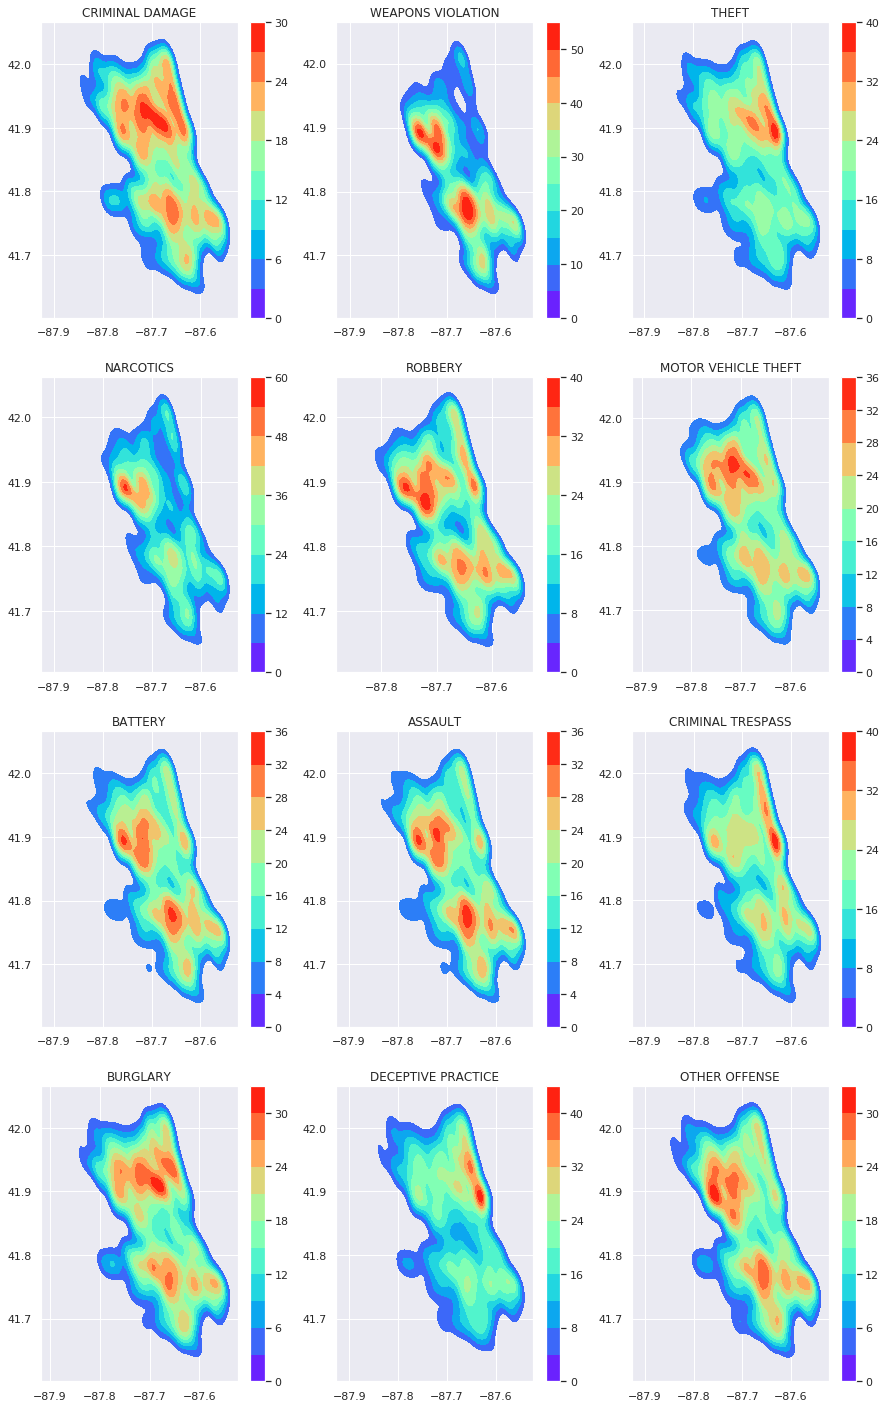

In [110]:
fig = plt.figure(figsize=(15,25))
n_col = 3
n_row = int(np.ceil(len(ptypes)/n_col))
for i, ptype in enumerate(ptypes):
    start = time.time()
    ax = fig.add_subplot(n_row,n_col,(i+1))
    _df = rounded_loc_type.filter(F.col("Primary Type")== ptype).toPandas()[:75000]
    sns.kdeplot(
        X='RoundedLong',
        Y='RoundedLat',
        ax=ax,
        data = _df[["RoundedLong","RoundedLat"]],
        cmap='rainbow',
        shade=True,
        cbar=True,
        shade_lowest=False
    )
    ax.set_title(ptype)
    print("Done with ", ptype, " in ", round((time.time()- start),1) , " seconds")
    
plt.show()

Create a plot of two types with clear difference

In [111]:
theft = rounded_loc_type.filter(F.col("Primary Type")== "THEFT").toPandas()[:150000]
battery = rounded_loc_type.filter(F.col("Primary Type")== "BATTERY").toPandas()[:150000]

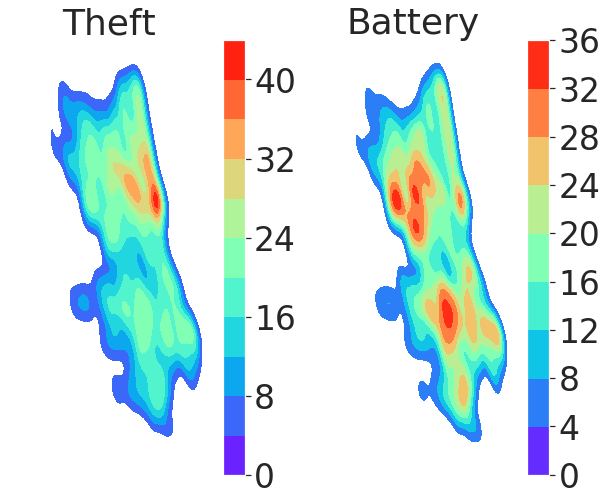

In [118]:
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.set_axis_off()
ax2.set_axis_off()

sns.set(font_scale = 3)

sns.kdeplot(
    X='RoundedLong',
    Y='RoundedLat',
    ax=ax1,
    data = theft[["RoundedLong","RoundedLat"]][:],
    cmap='rainbow',
    shade=True,
    cbar=True,
    shade_lowest=False
)
sns.kdeplot(
    X='RoundedLong',
    Y='RoundedLat',
    ax=ax2,
    data = battery[["RoundedLong","RoundedLat"]][:],
    cmap='rainbow',
    shade=True,
    cbar=True,
    shade_lowest=False
)

ax1.set_title("Theft")
ax2.set_title("Battery")

plt.savefig('loc_type.png')
plt.show()